In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.decomposition import PCA, FastICA,TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


In [41]:
%%time
sql_query ="SELECT a.[PurchaseDate] \
      ,MONTH(a.[PurchaseDate]) Month \
      ,a.[PartnerID] \
      ,IIF(SEX='M',1,0) SEX \
      ,IIF(DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])> 100 , 0 , DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])) Age \
      ,[CityID] \
      ,DATEDIFF(DAY, [FirstVisit],a.[PurchaseDate])/30.0 LT  \
      ,DATEDIFF(DAY, t.LastDate,a.[PurchaseDate])/30.0 LastVisit_M  \
      ,[FirstVisit] \
      ,[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend] \
      ,IIF(LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID,0,1) LastPurchase \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMZoloto],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMZoloto] IS NULL,0,1)), \
      1,0) NextGold \
  FROM [Gold585].[dbo].[TempPurch3] a left join [Gold585].[dbo].TempDate2 t on a.PartnerID = t.PartnerID and a.PurchaseDate = t.PurchaseDate \
  order by PartnerID, PurchaseDate"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 5min 54s


необходимые таблицы для прогноза - TempPurch3 и ##TempDate или (TempDate)

In [152]:
%%time
sql_query ="SELECT a.[PurchaseDate] \
      ,MONTH(a.[PurchaseDate]) Month \
      ,a.[PartnerID] \
      ,IIF(SEX='M',1,0) SEX \
      ,IIF(DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])> 100 , 0 , DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])) Age \
      ,[CityID] \
      ,DATEDIFF(DAY, [FirstVisit],a.[PurchaseDate])/30.0 LT  \
      ,DATEDIFF(DAY, t.LastDate,a.[PurchaseDate])/30.0 LastVisit_M  \
      ,[FirstVisit] \
      ,[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend] \
      ,IIF(LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID,0,1) LastPurchase \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMZoloto],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMZoloto] IS NULL,0,1)), \
      1,0) NextGold \
  FROM [Gold585].[dbo].[TempPurch3] a left join [Gold585].[dbo].TempDate2 t on a.PartnerID = t.PartnerID and a.PurchaseDate = t.PurchaseDate \
  order by PartnerID, PurchaseDate"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 6min 37s


In [42]:
pred = df[df['LastPurchase']==1].fillna(0).reset_index(drop=True)
predId = pd.DataFrame(df['PartnerID'][df['LastPurchase']==1],columns=['PartnerID']).reset_index(drop=True)
data = df[df['LastPurchase']!=1].fillna(0).reset_index(drop=True)
pred.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,LastPurchase,NextGold
0,2016-01-24,1,10,0,20,105,0.000000,0.000000,2016-01-24,1,...,0,0,0,0,1,0,0,0,1,0
1,2016-01-24,1,100,1,28,36,0.000000,0.000000,2016-01-24,1,...,0,0,0,1,0,0,0,0,1,0
2,2018-09-13,9,1000,0,0,30,32.066666,8.233333,2016-01-25,7,...,0,1,3,5,3,0,2,0,1,0
3,2017-03-04,3,1000037,0,25,47,15.833333,15.833333,2015-11-15,2,...,0,0,0,2,0,0,0,0,1,0
4,2016-01-23,1,1000038,1,0,20,0.000000,0.000000,2016-01-23,1,...,0,0,0,1,0,0,0,0,1,0


In [43]:
data.head(10)

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,LastPurchase,NextGold
0,2016-01-25,1,1000,0,0,30,0.000000,0.000000,2016-01-25,1,...,0,0,0,2,0,0,0,0,0,0
1,2016-12-11,12,1000,0,0,30,10.700000,10.700000,2016-01-25,2,...,0,0,0,2,0,0,1,0,0,1
2,2017-01-20,1,1000,0,0,30,12.033333,1.333333,2016-01-25,3,...,0,0,0,3,2,0,1,0,0,1
3,2017-02-13,2,1000,0,0,30,12.833333,0.800000,2016-01-25,4,...,0,1,2,3,3,0,1,0,0,1
4,2017-07-10,7,1000,0,0,30,17.733333,4.900000,2016-01-25,5,...,0,1,3,3,3,0,1,0,0,1
5,2018-01-09,1,1000,0,0,30,23.833333,6.100000,2016-01-25,6,...,0,1,3,4,3,0,2,0,0,1
6,2015-11-15,11,1000037,0,23,47,0.000000,0.000000,2015-11-15,1,...,0,0,0,1,0,0,0,0,0,1
7,2015-03-20,3,1000244,0,49,36,0.000000,0.000000,2015-03-20,1,...,0,0,0,1,0,0,0,0,0,1
8,2015-11-23,11,100034,1,33,118,0.000000,0.000000,2015-11-23,1,...,0,0,0,0,1,0,0,0,0,1
9,2015-12-26,12,100034,1,33,118,1.100000,1.100000,2015-11-23,2,...,0,0,1,0,1,0,0,0,0,1


In [44]:
data.shape

(2280623, 57)

In [45]:
print(data['NextGold'].value_counts())
#print(data['NextSerebro'].value_counts())

1    1754318
0     526305
Name: NextGold, dtype: int64


In [46]:
data['NextGold'].value_counts()

1    1754318
0     526305
Name: NextGold, dtype: int64

In [47]:
data.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'LastPurchase', 'NextGold'],
      dtype='object')

In [48]:
data1 = data[data['NextGold']==1].sample(700000)
data0 = data[data['NextGold']!=1]

all_data = data
X = pd.concat([data1,data0],axis=0,ignore_index=True)
X.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,LastPurchase,NextGold
0,2018-06-11,6,6215310,0,23,62,0.000000,0.000000,2018-06-11,1,...,0,0,0,0,1,0,0,0,0,1
1,2014-11-27,11,1459742,0,40,30,0.000000,0.000000,2014-11-27,1,...,0,0,0,1,0,0,0,0,0,1
2,2015-09-21,9,1902539,0,46,64,0.766666,0.766666,2015-08-29,2,...,0,0,2,0,0,0,0,0,0,1
3,2015-07-11,7,1799774,1,41,13,0.000000,0.000000,2015-07-11,1,...,0,0,0,1,0,0,0,0,0,1
4,2018-03-02,3,4867704,0,35,92,6.933333,1.733333,2017-08-06,10,...,0,0,2,5,3,2,0,0,0,1


In [49]:
X.tail()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,LastPurchase,NextGold
1226300,2014-03-18,3,997790,0,21,122,0.000000,0.000000,2014-03-18,1,...,0,0,0,1,0,0,0,0,0,0
1226301,2014-11-11,11,997795,0,38,92,0.000000,0.000000,2014-11-11,1,...,0,0,0,1,0,0,0,0,0,0
1226302,2014-12-30,12,997795,0,38,92,1.633333,1.633333,2014-11-11,2,...,0,0,0,2,0,0,0,0,0,0
1226303,2015-12-28,12,997795,0,39,92,13.733333,12.100000,2014-11-11,3,...,0,0,0,2,1,0,0,0,0,0
1226304,2014-12-02,12,999716,0,47,114,0.000000,0.000000,2014-12-02,1,...,0,1,0,1,0,0,0,0,0,0


In [50]:
X.shape

(1226305, 57)

In [51]:
X.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'LastPurchase', 'NextGold'],
      dtype='object')

In [52]:
%%time
#a = X['QNTVisits'].quantile(0.99)
#b = X['SumSumma'].quantile(0.99)
#X = X[X['QNTVisits']<a].reset_index(drop=True)
#X = X[X['SumSumma']<b].reset_index(drop=True)

Wall time: 0 ns


In [53]:
X.shape
X['NextGold'].value_counts()

1    700000
0    526305
Name: NextGold, dtype: int64

In [54]:
y=X['NextGold']
all_y = all_data['NextGold']
X.drop(['PurchaseDate','FirstVisit','LastPurchase','NextGold'],axis=1,inplace=True)
all_data.drop(['PurchaseDate','FirstVisit','LastPurchase','NextGold'],axis=1,inplace=True)
pred.drop(['PurchaseDate','FirstVisit','LastPurchase','NextGold'],axis=1,inplace=True)

In [55]:
print(X.shape)
print(len(y))
print(all_data.shape)
print(len(all_y))
print(pred.shape)

(1226305, 53)
1226305
(2280623, 53)
2280623
(2648950, 53)


In [56]:
X.head()

,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,...,SUMColorYellow,SUMColorWhite,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend
0,6,6215310,0,23,62,0.000000,0.000000,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,11,1459742,0,40,30,0.000000,0.000000,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,9,1902539,0,46,64,0.766666,0.766666,2,0,2,...,0,1,0,0,2,0,0,0,0,0
3,7,1799774,1,41,13,0.000000,0.000000,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,3,4867704,0,35,92,6.933333,1.733333,10,3,12,...,0,7,0,0,2,5,3,2,0,0


In [57]:
%%time
for_norm = pd.concat((X,pred),axis=0,ignore_index=True)

Wall time: 2.9 s


In [58]:
for_norm.columns

Index(['Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT', 'LastVisit_M',
       'QNTVisits', 'SumSMS', 'SumQuantity', 'SumSumma', 'AVGSumma', 'SUMM1',
       'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9',
       'SUMM10', 'SUMM11', 'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k',
       'SUMP50k', 'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'SUMColorBlack', 'SUMColorRed',
       'SUMColorYellow', 'SUMColorWhite', 'SUMColor3', 'SUMColor2',
       'SUMGroupBaza', 'SUMGroupClassic', 'SUMGroupModa', 'SUMGroupModul',
       'SUMGroupSouvenir', 'SUMGroupTrend'],
      dtype='object')

In [59]:
%%time
for_norm = pd.get_dummies(for_norm, columns = ['CityID'],drop_first=True)
all_data = pd.get_dummies(all_data, columns = ['CityID'],drop_first=True)

Wall time: 17.5 s


In [60]:
all_data.shape

(2280623, 172)

In [61]:
for_norm.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,6,6215310,0,23,0.000000,0.000000,1,0,1,7581.0,...,0,0,0,0,0,0,0,0,0,0
1,11,1459742,0,40,0.000000,0.000000,1,0,1,2459.0,...,0,0,0,0,0,0,0,0,0,0
2,9,1902539,0,46,0.766666,0.766666,2,0,2,10117.0,...,0,0,0,0,0,0,0,0,0,0
3,7,1799774,1,41,0.000000,0.000000,1,0,1,4784.0,...,0,0,0,0,0,0,0,0,0,0
4,3,4867704,0,35,6.933333,1.733333,10,3,12,27204.9,...,0,0,0,0,0,0,0,0,0,0


In [62]:
%%time
scaler = StandardScaler()
scaler.fit(for_norm)
for_norm_s = scaler.transform(for_norm)
all_data_s = scaler.transform(all_data)

Wall time: 2min 22s


In [63]:
all_data_s.shape

(2280623, 172)

In [64]:
for_norm_s= pd.DataFrame(for_norm_s,columns=for_norm.columns)
all_data = pd.DataFrame(all_data_s,columns=all_data.columns)

In [65]:
X = for_norm_s[:X.shape[0]]
pred = for_norm_s[X.shape[0]:]
print(X.shape)
print(y.shape)
print(all_data.shape)
print(len(all_y))
print(pred.shape)

(1226305, 172)
(1226305,)
(2280623, 172)
2280623
(2648950, 172)


In [66]:
pd.DataFrame(X).head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,-0.258827,1.752221,-0.654329,-0.699080,-0.508710,-0.431278,-0.081563,-0.216111,-0.082092,-0.053067,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546
1,1.136688,-1.029689,-0.654329,0.320743,-0.508710,-0.431278,-0.081563,-0.216111,-0.082092,-0.080001,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546
2,0.578482,-0.770662,-0.654329,0.680681,-0.433517,-0.310119,-0.030689,-0.216111,-0.054586,-0.039731,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546
3,0.020276,-0.830777,1.528282,0.380733,-0.508710,-0.431278,-0.081563,-0.216111,-0.082092,-0.067775,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546
4,-1.096136,0.963899,-0.654329,0.020795,0.171293,-0.157352,0.376307,5.823299,0.220479,0.050128,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546


In [67]:
pred.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
1226305,-1.654342,-1.883602,-0.654329,-0.879049,-0.508710,-0.431278,-0.081563,-0.216111,-0.082092,-0.090450,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546
1226306,-1.654342,-1.883550,1.528282,-0.399132,-0.508710,-0.431278,-0.081563,-0.216111,-0.082092,-0.017208,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546
1226307,0.578482,-1.883023,-0.654329,-2.078841,2.636303,0.869869,0.223684,-0.216111,0.247985,0.037697,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546
1226308,-1.096136,-1.298607,-0.654329,-0.579101,1.044181,2.070927,-0.030689,-0.216111,-0.054586,-0.044763,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546
1226309,-1.654342,-1.298606,1.528282,-2.078841,-0.508710,-0.431278,-0.081563,-0.216111,-0.082092,-0.062390,...,-0.025438,-0.068637,-0.115701,-0.144344,-0.101228,-0.082355,-0.019743,-0.014812,-0.0289,-0.084546


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y,shuffle =True)

In [69]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [100],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
   # 'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC, param_grid=param_grid, cv= 5)
model.fit(X_train, y_train)
#ExTC.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
#predicted = ExTC.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.86      0.85      0.85    131577
          1       0.89      0.90      0.89    175000

avg / total       0.88      0.88      0.88    306577

[[111714  19863]
 [ 18092 156908]]
0.8728280543169182
Wall time: 8min 49s


In [70]:
predicted_proba = model.predict_proba(X_test)

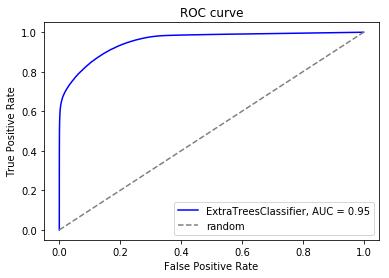

In [73]:
preds = predicted_proba[:,1]
fpr, tpr, treshold = metrics.roc_curve(expected, preds)
roc_auc = metrics.auc(fpr, tpr)
pylab.title('ROC curve')
pylab.plot(fpr, tpr,'b', label = 'ExtraTreesClassifier, AUC = %0.2f' % roc_auc)
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.legend(loc = 'lower right')

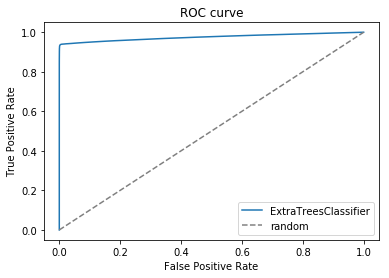

In [37]:
fpr, tpr, _ = metrics.roc_curve(expected, predicted_proba[:,1])
pylab.plot(fpr, tpr, label = 'ExtraTreesClassifier')
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve')
pylab.legend(loc = 'lower right')

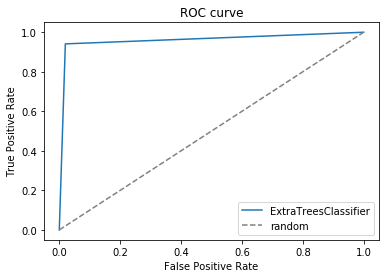

In [40]:
fpr, tpr, _ = metrics.roc_curve(expected, predicted)
pylab.plot(fpr, tpr, label = 'ExtraTreesClassifier')
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve')
pylab.legend(loc = 'lower right')

In [188]:
from catboost import CatBoostClassifier
from catboost import Pool

#cat_features = []
train_data = X_train
train_labels = y_train
test_data = X_test

p = Pool(X_train, y_train ) #,cat_features=cat_features)

model = CatBoostClassifier(iterations=1000, learning_rate=0.5, depth=7, loss_function='Logloss',silent=False)

model.fit(p)
# Прогноз класса
preds_class = model.predict(test_data)
# Прогноз вероятности каждого класса
preds_proba = model.predict_proba(test_data)

# Проверка модели
print(metrics.classification_report(y_test, preds_class))
print(metrics.confusion_matrix(y_test, preds_class))
print(roc_auc_score(y_test, preds_class))

0:	learn: 0.2643243	total: 1.09s	remaining: 18m 14s
1:	learn: 0.2383155	total: 2.16s	remaining: 17m 57s
2:	learn: 0.2334766	total: 3.19s	remaining: 17m 39s
3:	learn: 0.2321240	total: 4.26s	remaining: 17m 40s
4:	learn: 0.2316114	total: 5.34s	remaining: 17m 43s
5:	learn: 0.2312628	total: 6.4s	remaining: 17m 40s
6:	learn: 0.2309315	total: 7.47s	remaining: 17m 40s
7:	learn: 0.2308185	total: 8.59s	remaining: 17m 44s
8:	learn: 0.2306750	total: 9.67s	remaining: 17m 44s
9:	learn: 0.2305563	total: 10.8s	remaining: 17m 46s
10:	learn: 0.2304928	total: 11.9s	remaining: 17m 45s
11:	learn: 0.2304153	total: 12.9s	remaining: 17m 41s
12:	learn: 0.2303158	total: 14s	remaining: 17m 43s
13:	learn: 0.2302355	total: 15.1s	remaining: 17m 42s
14:	learn: 0.2301171	total: 16.2s	remaining: 17m 42s
15:	learn: 0.2300381	total: 17.3s	remaining: 17m 41s
16:	learn: 0.2299618	total: 18.3s	remaining: 17m 40s
17:	learn: 0.2298927	total: 19.4s	remaining: 17m 40s
18:	learn: 0.2298184	total: 20.5s	remaining: 17m 36s
19:	le

154:	learn: 0.2246510	total: 2m 48s	remaining: 15m 20s
155:	learn: 0.2246152	total: 2m 49s	remaining: 15m 19s
156:	learn: 0.2245726	total: 2m 50s	remaining: 15m 17s
157:	learn: 0.2245227	total: 2m 52s	remaining: 15m 16s
158:	learn: 0.2244965	total: 2m 53s	remaining: 15m 15s
159:	learn: 0.2244805	total: 2m 54s	remaining: 15m 14s
160:	learn: 0.2244368	total: 2m 55s	remaining: 15m 13s
161:	learn: 0.2243977	total: 2m 56s	remaining: 15m 11s
162:	learn: 0.2243797	total: 2m 57s	remaining: 15m 10s
163:	learn: 0.2243612	total: 2m 58s	remaining: 15m 9s
164:	learn: 0.2243311	total: 2m 59s	remaining: 15m 8s
165:	learn: 0.2243043	total: 3m	remaining: 15m 7s
166:	learn: 0.2242521	total: 3m 1s	remaining: 15m 6s
167:	learn: 0.2242237	total: 3m 2s	remaining: 15m 4s
168:	learn: 0.2241929	total: 3m 3s	remaining: 15m 3s
169:	learn: 0.2241602	total: 3m 4s	remaining: 15m 2s
170:	learn: 0.2241422	total: 3m 5s	remaining: 15m 1s
171:	learn: 0.2241210	total: 3m 7s	remaining: 15m
172:	learn: 0.2240756	total: 3m 

305:	learn: 0.2200526	total: 5m 33s	remaining: 12m 37s
306:	learn: 0.2200096	total: 5m 34s	remaining: 12m 35s
307:	learn: 0.2199713	total: 5m 35s	remaining: 12m 34s
308:	learn: 0.2199445	total: 5m 37s	remaining: 12m 33s
309:	learn: 0.2199204	total: 5m 38s	remaining: 12m 32s
310:	learn: 0.2199007	total: 5m 39s	remaining: 12m 31s
311:	learn: 0.2198587	total: 5m 40s	remaining: 12m 30s
312:	learn: 0.2198154	total: 5m 41s	remaining: 12m 28s
313:	learn: 0.2197859	total: 5m 42s	remaining: 12m 27s
314:	learn: 0.2197577	total: 5m 43s	remaining: 12m 26s
315:	learn: 0.2197126	total: 5m 44s	remaining: 12m 25s
316:	learn: 0.2196709	total: 5m 45s	remaining: 12m 24s
317:	learn: 0.2196415	total: 5m 46s	remaining: 12m 23s
318:	learn: 0.2196133	total: 5m 47s	remaining: 12m 21s
319:	learn: 0.2195942	total: 5m 48s	remaining: 12m 20s
320:	learn: 0.2195822	total: 5m 49s	remaining: 12m 19s
321:	learn: 0.2195475	total: 5m 50s	remaining: 12m 18s
322:	learn: 0.2195294	total: 5m 51s	remaining: 12m 17s
323:	learn

456:	learn: 0.2159376	total: 8m 16s	remaining: 9m 49s
457:	learn: 0.2159071	total: 8m 17s	remaining: 9m 48s
458:	learn: 0.2158868	total: 8m 18s	remaining: 9m 47s
459:	learn: 0.2158646	total: 8m 19s	remaining: 9m 46s
460:	learn: 0.2158477	total: 8m 20s	remaining: 9m 45s
461:	learn: 0.2158135	total: 8m 21s	remaining: 9m 44s
462:	learn: 0.2157872	total: 8m 22s	remaining: 9m 42s
463:	learn: 0.2157727	total: 8m 23s	remaining: 9m 41s
464:	learn: 0.2157413	total: 8m 24s	remaining: 9m 40s
465:	learn: 0.2157174	total: 8m 25s	remaining: 9m 39s
466:	learn: 0.2156874	total: 8m 26s	remaining: 9m 38s
467:	learn: 0.2156694	total: 8m 27s	remaining: 9m 37s
468:	learn: 0.2156522	total: 8m 28s	remaining: 9m 36s
469:	learn: 0.2156346	total: 8m 29s	remaining: 9m 35s
470:	learn: 0.2156102	total: 8m 31s	remaining: 9m 34s
471:	learn: 0.2155789	total: 8m 32s	remaining: 9m 32s
472:	learn: 0.2155463	total: 8m 33s	remaining: 9m 31s
473:	learn: 0.2155122	total: 8m 34s	remaining: 9m 30s
474:	learn: 0.2154964	total:

608:	learn: 0.2120261	total: 11m	remaining: 7m 3s
609:	learn: 0.2120110	total: 11m 1s	remaining: 7m 2s
610:	learn: 0.2119698	total: 11m 2s	remaining: 7m 1s
611:	learn: 0.2119568	total: 11m 3s	remaining: 7m
612:	learn: 0.2119213	total: 11m 4s	remaining: 6m 59s
613:	learn: 0.2118826	total: 11m 5s	remaining: 6m 58s
614:	learn: 0.2118535	total: 11m 6s	remaining: 6m 57s
615:	learn: 0.2118181	total: 11m 7s	remaining: 6m 56s
616:	learn: 0.2118058	total: 11m 8s	remaining: 6m 55s
617:	learn: 0.2117772	total: 11m 9s	remaining: 6m 53s
618:	learn: 0.2117385	total: 11m 10s	remaining: 6m 52s
619:	learn: 0.2117096	total: 11m 11s	remaining: 6m 51s
620:	learn: 0.2116742	total: 11m 12s	remaining: 6m 50s
621:	learn: 0.2116643	total: 11m 13s	remaining: 6m 49s
622:	learn: 0.2116392	total: 11m 15s	remaining: 6m 48s
623:	learn: 0.2116287	total: 11m 16s	remaining: 6m 47s
624:	learn: 0.2116039	total: 11m 17s	remaining: 6m 46s
625:	learn: 0.2115890	total: 11m 18s	remaining: 6m 45s
626:	learn: 0.2115626	total: 1

759:	learn: 0.2083112	total: 13m 44s	remaining: 4m 20s
760:	learn: 0.2082928	total: 13m 45s	remaining: 4m 19s
761:	learn: 0.2082814	total: 13m 46s	remaining: 4m 18s
762:	learn: 0.2082577	total: 13m 47s	remaining: 4m 17s
763:	learn: 0.2082304	total: 13m 48s	remaining: 4m 16s
764:	learn: 0.2081988	total: 13m 49s	remaining: 4m 14s
765:	learn: 0.2081609	total: 13m 50s	remaining: 4m 13s
766:	learn: 0.2081451	total: 13m 52s	remaining: 4m 12s
767:	learn: 0.2081076	total: 13m 53s	remaining: 4m 11s
768:	learn: 0.2080817	total: 13m 54s	remaining: 4m 10s
769:	learn: 0.2080598	total: 13m 55s	remaining: 4m 9s
770:	learn: 0.2080358	total: 13m 56s	remaining: 4m 8s
771:	learn: 0.2080075	total: 13m 57s	remaining: 4m 7s
772:	learn: 0.2079994	total: 13m 58s	remaining: 4m 6s
773:	learn: 0.2079800	total: 13m 59s	remaining: 4m 5s
774:	learn: 0.2079642	total: 14m	remaining: 4m 3s
775:	learn: 0.2079349	total: 14m 1s	remaining: 4m 2s
776:	learn: 0.2079149	total: 14m 2s	remaining: 4m 1s
777:	learn: 0.2079008	to

910:	learn: 0.2047797	total: 16m 26s	remaining: 1m 36s
911:	learn: 0.2047500	total: 16m 27s	remaining: 1m 35s
912:	learn: 0.2047209	total: 16m 29s	remaining: 1m 34s
913:	learn: 0.2047091	total: 16m 30s	remaining: 1m 33s
914:	learn: 0.2046799	total: 16m 31s	remaining: 1m 32s
915:	learn: 0.2046617	total: 16m 32s	remaining: 1m 31s
916:	learn: 0.2046511	total: 16m 33s	remaining: 1m 29s
917:	learn: 0.2046379	total: 16m 35s	remaining: 1m 28s
918:	learn: 0.2046171	total: 16m 36s	remaining: 1m 27s
919:	learn: 0.2046033	total: 16m 37s	remaining: 1m 26s
920:	learn: 0.2045867	total: 16m 38s	remaining: 1m 25s
921:	learn: 0.2045576	total: 16m 39s	remaining: 1m 24s
922:	learn: 0.2045431	total: 16m 41s	remaining: 1m 23s
923:	learn: 0.2045212	total: 16m 42s	remaining: 1m 22s
924:	learn: 0.2045077	total: 16m 43s	remaining: 1m 21s
925:	learn: 0.2044827	total: 16m 44s	remaining: 1m 20s
926:	learn: 0.2044590	total: 16m 45s	remaining: 1m 19s
927:	learn: 0.2044420	total: 16m 46s	remaining: 1m 18s
928:	learn

In [181]:
print(roc_auc_score(all_y, model.predict(all_data)))
#print(roc_auc_score(all_y, ExTC.predict(all_data)))

0.9450232330762144


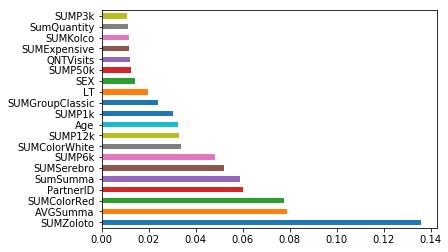

In [186]:
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [33]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.25, random_state=42,stratify=y_s,shuffle =True)

In [187]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [100],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
   # 'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC, param_grid=param_grid, cv= 5)
model.fit(X_train_s, y_train_s)
#ExTC.fit(X_train_s, y_train_s)
#print(model)
# make predictions
expected = y_test_s
predicted = model.predict(X_test_s)
#predicted = ExTC.predict(X_test_s)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.68      0.76      0.72    172267
          1       0.72      0.64      0.68    167291

avg / total       0.70      0.70      0.70    339558

[[130205  42062]
 [ 60064 107227]]
0.6983967380234427
Wall time: 13min 44s


In [94]:
model.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [48]:
predict = ExTC.predict(pred)

In [49]:
predictedID_metall = pd.concat([predId,pd.DataFrame(predict,columns=['Zoloto'])],axis=1,ignore_index=False)

In [50]:
predictedID_metall.head()

,PartnerID,Zoloto
0,10,0
1,100,1
2,1000,1
3,1000037,1
4,1000038,1


In [51]:
predictedID_metall['Zoloto'].value_counts()

1    1644809
0    1004141
Name: Zoloto, dtype: int64

In [285]:
predictedID_metall.to_csv('metal_pred.csv')